# Projet INDEED

3 grandes parties :
- Scrapping et réalistion de base de données
- Preprocessing / NLP
- Machine learning pour prédire les salaires


# Le Scraping

Réaliser un programme qui permet de récupérer le maximum d'annonces concernant les métiers suivants :  
- développeur
- business intelligence
- data scientist
- data science
- data analyst
- data engineer
- data architect
- data protection
- data manager
- data concepteur
- big data
- devops
- web developer
- full stack developer
- web architect
- front end developer
- back end developer

dans ces 5 parties de France :
- Île de France
- Lyon
- Bordeaux
- Nantes
- Toulouse

et de les stocker dans une base de données de type MongoDB

# Partie 1 - Préprocessing des données

Extraire des variables explicatives, afin de prédire les salaires manquants dans les données scrappées

Type de variables explicatives choisies :

- en lien avec le titre du métier (séparation des métiers en 2 poles : "dev" et "data")
   
- en lien avec le niveau d'étude (Bac+3 / Bac+5 et Bac +8)

/!\ Bac +3 englobe : BTS/IUT/Licence/BSc
/!\ Bac +5 englobe : Master/ingenieur/MSc/grandes écoles
/!\ Bac +8 englobe : PhD/doctorat/docteur
    
- en lien avec les années d'expérience demandées

/!\ lorsque qu'un intervalle d'années d'expérience est demandé, nous avons gardé la moyenne
/!\ lorsque les années d'expérence sont supérieures à 13, nous n'avons pas gardé la valeus 
Pourquoi ? il s'agit la plupart du temps d'une description de la société.

- en lien avec l'expérience
la présence du mot junior (et ses dérivés : jeune diplomé/novice) et celle de senior (et ses dérivés: expérimenté/confirmé)

- en lien avec la géographie 

- en lien avec le type de contrat

Finalement, après plusieurs test, nous avons décidé de ne plus utilisé la variable explicative concernant les années d'expériences, car nous n'avions pas assez de données.
De plus, nous avons préféré séparer les salaires en fonction du lieu plutôt que des poles dev versus data. Les résultats étant meilleurs lors de la séparation selon la géographie (province versus île de France).

# Partie 2 - Le machine learning

Test et comparaison de plusieurs algorithmes de ML afin de prédire au mieux les salaires manquants

Algorithmes testés:

- Random Forest
- SVM Kernel 'linear' 
- SVM Kernel 'rbf'
- Adaboost
- XGBoost

Métriques utilisées :
- accuracy_train
- accuracy_test
- recall_train
- f1_train
- cross_validation

Un premier round d'algorithme a été lancée, pour évaluer la pertinence des groupes de salaire réalisés, une fois les groupes pertinents repérés, nous avons utilisés grid search afin d'améliorer les métriques, et nous avons relancés un second round de machine learning.

## Partie 1 - Le Preprocessing

In [1]:
# PACKAGE A IMPORTER

import pandas as pd
import json
import unidecode
import re
import numpy as np
from sklearn import svm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.spatial.distance import cdist
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Lecture de json de la base de données

In [ ]:
data = pd.read_json('indeed6.json', encoding = 'utf-8', lines=True)

Retrait des accents et de la ponctuation sur les différentes colonnes à traiter

In [ ]:
def remove_accents(a):
    #a = a.replace("é", "e")
    #a = a.replace("à", "a")
    return unidecode.unidecode(a)

data["texte"] = data.texte.apply(remove_accents)
data["texte"] = data.texte.str.lower()
data["texte"] = data.texte.astype(str)

data["query_contrat"] = data.query_contrat.apply(remove_accents)
data["query_contrat"] = data.query_contrat.str.lower()
data["query_contrat"] = data.query_contrat.astype(str)

data["query_ville"] = data.query_ville.apply(remove_accents)
data["query_ville"] = data.query_ville.str.lower()
data["query_ville"] = data.query_ville.astype(str)

data["titre"] = data.titre.apply(remove_accents)
data["titre"] = data.titre.str.lower()
data["titre"] = data.titre.astype(str)

data["query_poste"] = data.query_poste.apply(remove_accents)
data["query_poste"] = data.query_poste.str.lower()
data["query_poste"] = data.query_poste.astype(str)

# Création des variables explicatives en lien avec la géographie

Une annonce (avec une seule ID) pouvant être publiée dans plusieurs villes, nous avons décidé de creer 5 colonnes (pour les 5 villes) et de mettre des 1 dans les colonnes si la ou les villes sont concernées par l'annonce et 0 si non. 

In [ ]:
def pole_ville (data):
    liste_nantes = [0]*len(data)
    liste_bordeaux = [0]*len(data)
    liste_idf = [0]*len(data)
    liste_lyon = [0]*len(data)
    liste_toulouse = [0]*len(data)
    
    for i in range(len(data.query_ville)):
        if re.findall('nantes',data.query_ville[i]):
            liste_nantes[i] = 1
        elif re.findall('bordeaux',data.query_ville[i]):
            liste_bordeaux[i] = 1
        elif re.findall('lyon',data.query_ville[i]):
            liste_lyon[i] = 1
        elif re.findall('toulouse',data.query_ville[i]):
            liste_toulouse[i] = 1
        elif re.findall('ile-de-france',data.query_ville[i]):
            liste_idf[i] = 1
        
    data['Nantes'] = liste_nantes
    data['Bordeaux'] = liste_bordeaux
    data['Idf'] = liste_idf
    data['Lyon'] = liste_lyon
    data['Toulouse'] = liste_toulouse

# Création des variables explicatives en lien avec le contract

De même que pour les villes, une même annonce peut donner lieu à differents types de contract. Nous avons créer 5 colonnes ( 4 types de contract et une colonne contract inconnu), un 1 est ajouté lorsque le ou les contrats sont mentionnés dans l'annonce, 0 si non (et 1 dans la colonne contrat inconnu).

In [ ]:
def pole_contract (data):
    liste_CDI = [0]*len(data)
    liste_CDD = [0]*len(data)
    liste_freelance_interim = [0]*len(data)
    liste_stage_apprentissage = [0]*len(data)
    liste_inconnu = [0]*len(data)
    
    for i in range(len(data.query_contrat)):
        if re.findall('(internship|custom_1|apprenticeship)',data.query_contrat[i]):
            liste_stage_apprentissage[i] = 1
        elif re.findall('(temporary|subcontract)',data.query_contrat[i]):
            liste_freelance_interim[i] = 1
        elif re.findall('contract',data.query_contrat[i]):
            liste_CDD[i] = 1
        elif re.findall('permanent',data.query_contrat[i]):
            liste_CDI[i] = 1
        else :
            liste_inconnu[i] = 1
        
    data['CDI'] = liste_CDI
    data['CDD'] = liste_CDD
    data['freelance_interim'] = liste_freelance_interim
    data['stage_apprentissage'] = liste_stage_apprentissage
    data['inconnu'] = liste_inconnu

# Création des variables explicatives en lien avec le pole d'activité (Dev et Data)

Nous avions décidé de séparer les emplois en 2 pôles : le pôle data et le pôle dev.
Cependant, lors de machine learning, nous avons arrêter d'utiliser cette variable explicative.

In [ ]:
def pole_travail (data):
    liste_pole_dev = [0]*len(data)
    liste_pole_data = [0]*len(data)
    
    for i in range(len(data.query_poste)):
        if re.findall('(dev|web)',data.query_poste[i]):
            liste_pole_dev[i] = 1
        if re.findall('(data|intelligence)',data.query_poste[i]):
            liste_pole_data[i] = 1
            
    data['dev'] = liste_pole_dev
    data['data'] = liste_pole_data

# Recherche des termes dans la description des annonces avec les RegEx (junior/senior, niveau d'étude, années d'expérience et salaires)

Nous avons souhaité creer des variables explicatives en lien le niveau d'étude, les année d'expériences demandées, l'expérience demandées (junior vs senior) et retrouver des salaires dans la description qui ne seraient pas forcément mentionnés dans le reste de l'annonce.

Nous avons lors du machine learning, retiré la variable liée aux années d'expérience demandées, n'ayant pas assez de données à ce sujet là.

In [ ]:
def terme_a_trouver (data):
    liste_junior = []
    liste_senior = []
    liste_bac_3 = []
    liste_bac_5 = []
    liste_bac_8 = []
    liste_exp = []
    liste_salaire = []
    
    for i in range(len(data.texte)):
        if re.findall('(jeune[es().]* diplome[es().]*|junior[s]*|novice[s]* | debutant[es().])', data.texte[i]):
            junior_i = re.findall('(jeune[es().]* diplome[es().]*|junior[s]*|novice[s]*)', data.texte[i])
            liste_junior.append(junior_i)
        else :
            liste_junior.append(np.nan)
    
    for i in range(len(data.texte)):
        if re.findall('(experimente[es().]*|senior[s]*|confirme[es().]*)', data.texte[i]):
            senior_i = re.findall('(experimente[es().]*|senior[s]*|confirme[es().]*)', data.texte[i])
            liste_senior.append(senior_i)
        else :
            liste_senior.append(np.nan)
            
    for i in range(len(data.texte)):
        if re.findall('(licence|bac[ +]*[23/]+| iut | dut | bts | bsc)', data.texte[i]):
            bac_3_i = re.findall('(licence|bac[ +]*[23/]+| iut | dut | bts | bsc)', data.texte[i])
            liste_bac_3.append(bac_3_i)
        else :
            liste_bac_3.append(np.nan)
            
    for i in range(len(data.texte)):
        if re.findall('(master|bac[ +]*5|ingenieur[.()es]*|grande[s]* ecole[s]*| msc)',data.texte[i]):
            bac_5_i = re.findall('(master|bac[ +]*5|ingenieur[.()es]*|grande[s]* ecole[s]*| msc)',data.texte[i])
            liste_bac_5.append(bac_5_i)
        else :
            liste_bac_5.append(np.nan)
    
    for i in range(len(data.texte)):
        if re.findall('(doctorat[s]*|docteur[.()es]*|ph[.]*d|these[s]*)',data.texte[i]):
            bac_8_i = re.findall('(doctorat[s]*|docteur[.()es]*|ph[.]*d|these[s]*)',data.texte[i])
            liste_bac_8.append(bac_8_i)
        else :
            liste_bac_8.append(np.nan)
    
    for i in range(len(data.texte)):
        if re.findall('(minimum [1-9]*[ /aou-]*\d+ an[nees]* d\'experience|[1-9]*[ /aou-]*\d+ an[nees]* d\'experience|[1-9]*[ /aou-]*\d+ an[nees]* minimum d\'experience)',data.texte[i]):
            exp_i = re.findall('(minimum [1-9]*[ /aou-]*\d+ an[nees]* d\'experience|[1-9]*[ /aou-]*\d+ an[nees]* d\'experience|[1-9]*[ /aou-]*\d+ an[nees]* minimum d\'experience)', data.texte[i])
            exp_i = ''.join(exp_i)
            exp_i = exp_i.replace("'", "")
            exp_i = exp_i.replace("-", "")
            exp_i = exp_i.replace(" ", "")
            #exp_ii = re.sub("[A-Za-z]", "", exp_i)
            liste_exp.append(exp_i)
        else :
            liste_exp.append(np.nan)
            
    for i in range(len(data.texte)):
        if re.findall('[\d+ ]*[ \-k€]*[\d+ ]*\d+,?\d+[ ]*[k€$]+',data.texte[i]):
            salaire_i = re.findall('[\d+ ]*[ \-k€]*[\d+ ]*\d+,?\d+[ ]*[kK€$]+',data.texte[i])
            salaire_i = ''.join(salaire_i)
            salaire_i = salaire_i.replace("k", "000")
            salaire_i = salaire_i.replace("K", "000")
            salaire_i = salaire_i.replace(" ", "")
            salaire_ii = re.sub("[A-Za-z]", "", salaire_i)
            liste_salaire.append(salaire_ii)
        else :
            liste_salaire.append(np.nan)
            
    data['junior'] = liste_junior
    data['senior'] = liste_senior
    data['bac_3'] = liste_bac_3
    data['bac_5'] = liste_bac_5
    data['bac_8'] = liste_bac_8
    data['experience'] = liste_exp
    data['salaire_texte'] = liste_salaire

In [ ]:
# LANCER LES DIFFERENTES FONCTIONS:
pole_ville(data)
pole_contract(data)
pole_travail(data)
terme_a_trouver(data)

# Transformation des données récupérées avec les RegEx 

Les termes trouvés via la recherche RegEx pour le niveau d'étude et les termes junior/senior sont remplacés par des 0 et 1 afin de pouvoir les utiliser lors du machine learning

In [ ]:
liste_zero_un = ["junior", "senior", "bac_3", "bac_5", "bac_8"]
for x in liste_zero_un:
    data[x] = data[x].replace(np.nan, 0)
    data[x] = np.where(data[x] !=0, 1, data[x])

# Transformation des données récupérées avec les RegEx 2

Les termes trouvés via les RegEx pour les années d'expériences sont transformés en float afin de pouvoir les utiliser lors du machine learning. 

In [ ]:
# TRANSFORMATION DES ANNEES D'EXPERIENCE EN FLOAT ET MODIFICATION DES VALEURS

def annee_exp (data):
    data.experience = data.experience.astype(str)
    liste_exp_demandee = []

    for i in range(len(data.experience)):
        #annee_exp commence par "^[1-9]{1,2}an" cad 1an ou 2annees
        if re.findall('^[0-9]{1,2}an',data.experience[i]):
            annee_exp = re.findall('^[0-9]{1,2}',data.experience[i])
            annee_exp = ''.join(annee_exp)
            annee_exp = float(annee_exp)
            if annee_exp < 12:
                liste_exp_demandee.append(annee_exp)
            else : 
                liste_exp_demandee.append(float(0))
                
        #annee_exp commence par "^[\/aou-]+[1-9]{1,2}" ou3
        elif re.findall("^[\/aou-]+[0-9]{1,2}",data.experience[i]):
            annee_exp = re.findall("[0-9]{1,2}",data.experience[i])
            annee_exp = ''.join(annee_exp)
            annee_exp = float(annee_exp)
            if annee_exp < 12:
                liste_exp_demandee.append(annee_exp)
            else : 
                liste_exp_demandee.append(float(0))
                
        #annee_exp commence par ^[1-9]+[\/aou-]*\d+ 1/2
        elif re.findall("^[1-9]+[\/aou-]+[0-9]+",data.experience[i]):
            x = re.findall("^[1-9]+[\/aou-]+[0-9]+",data.experience[i])
            x = ''.join(x)
            annee_exp_1 = re.findall("^[0-9]+",x)
            annee_exp_1 = ''.join(annee_exp_1)
            annee_exp_1 = float(annee_exp_1)
            annee_exp_2 = re.findall("[\/aou-]+[0-9]+",x)
            annee_exp_2 = ''.join(annee_exp_2)
            annee_exp_2 = re.sub("[a-zA-Z\/]*","",annee_exp_2)
            annee_exp_2 = ''.join(annee_exp_2)
            annee_exp_2 = float(annee_exp_2)
            annee_exp = (annee_exp_1 + annee_exp_2)/2
            if annee_exp < 12:
                liste_exp_demandee.append(annee_exp)
            else : 
                liste_exp_demandee.append(float(0))
                
        #annee_exp commence par minimum2 
        elif re.findall("^minimum[0-9]+",data.experience[i]):
            annee_exp = re.findall('minimum[0-9]+',data.experience[i])
            annee_exp = ''.join(annee_exp)
            annee_exp = re.sub("[a-zA-Z]","",annee_exp)
            annee_exp = ''.join(annee_exp)
            annee_exp = float(annee_exp)
            if annee_exp < 12:
                liste_exp_demandee.append(annee_exp)
            else : 
                liste_exp_demandee.append(float(0))
                
        #pour les NaN
        else :
            liste_exp_demandee.append(float(0))
            
    data['exp_demandee'] = liste_exp_demandee

# Transformation des données récupérées avec les RegEx 3

Les termes trouvés via les RegEx pour les salaires sont transformés en float afin de pouvoir les utiliser lors du machine learning. 

In [ ]:
def salaire_description (data):
    data.salaire_texte = data.salaire_texte.astype(str)
    liste_min = []
    liste_max = []
    
    for i in range(len(data.salaire_texte)):
        
        # Salaire de la forme : "30-45000+12000" OU "30-45000"
        if re.findall('^[0-9]{2}-\d+\+*',data.salaire_texte[i]):
            x_min = re.findall('^[0-9]{2}',data.salaire_texte[i])
            x_min = ''.join(x_min)
            x_min = x_min+"000"
            x_min = float(x_min)
            if re.findall('-[0-9]{5}\+',data.salaire_texte[i]):
                x_max = re.findall('-[0-9]{5}\+',data.salaire_texte[i])
                x_max = ''.join(x_max)
                x_max = x_max.replace("-", "")
                x_max = x_max.replace("+", "")
                x_max = float(x_max)
                if x_max > x_min:
                    liste_min.append(x_min)
                    liste_max.append(x_max)
                else :
                    liste_min.append(np.nan)
                    liste_max.append(np.nan)
                    
            else :
                x_max = re.findall('-[0-9]{5}',data.salaire_texte[i])
                x_max = ''.join(x_max)
                x_max = x_max.replace("-", "")
                x_max = float(x_max)
                if x_max > x_min:
                    liste_min.append(x_min)
                    liste_max.append(x_max)
                else :
                    liste_min.append(np.nan)
                    liste_max.append(np.nan)

        # Salaire de la forme : "30000-45000"
        elif re.findall('^[0-9]{5}-[0-9]{5}$',data.salaire_texte[i]):
            x_min = re.findall('^[0-9]{5}',data.salaire_texte[i])
            x_min = ''.join(x_min)
            x_min = float(x_min)
            x_max = re.findall('-[0-9]{5}$',data.salaire_texte[i])
            x_max = ''.join(x_max)
            x_max = x_max.replace("-", "")
            x_max = float(x_max)
            if x_max > x_min:
                liste_min.append(x_min)
                liste_max.append(x_max)
            else :
                liste_min.append(np.nan)
                liste_max.append(np.nan)
                
        # Salaire de la forme : "30000"
        elif re.findall('^[0-9]{5}$',data.salaire_texte[i]):
            x_unique = re.findall('^[0-9]{5}',data.salaire_texte[i])
            x_unique = ''.join(x_unique)
            x_unique = float(x_unique)
            liste_min.append(x_unique)
            liste_max.append(x_unique)
            #liste_unique.append(x_unique)

        # Salaire de la forme : "3000045000"
        elif re.findall('^[1-9]{1}[0-9]{4}[1-9]{1}[0-9]{4}$',data.salaire_texte[i]):
            x_min = re.findall('^[0-9]{5}',data.salaire_texte[i])
            x_min = ''.join(x_min)
            x_min = float(x_min)
            x_max = re.findall('[0-9]{5}$',data.salaire_texte[i])
            x_max = ''.join(x_max)
            x_max = x_max.replace("-", "")
            x_max = float(x_max)
            if x_max > x_min:
                liste_min.append(x_min)
                liste_max.append(x_max)
            else :
                liste_min.append(np.nan)
                liste_max.append(np.nan)
                
        else:
            liste_min.append(np.nan)
            liste_max.append(np.nan)
    
    data['min_alex'] = liste_min 
    data['max_alex'] = liste_max

In [ ]:
# LANCER LES DIFFERENTES FONCTIONS:
annee_exp(data)
salaire_description (data)

# Récupération des salaires présents dans la rubrique salaire lors du scrapping

In [ ]:
#Cette fonction nous permettra de travail sur des colonnes de string
def formatage_columns(column, replaced_strings, strings):
    column = column.astype(str)
    for i in range(len(column)):
        for x in range(len(replaced_strings)):
            column.iloc[i] = column.iloc[i].replace(replaced_strings[x], strings[x])
    
    return column

data['salaire'] = formatage_columns(data['salaire'], [" ", "par"], ["", " "])

#Les lignes avec le salaire horaire sont trop rare pour être significative, et potentiellement le produit d'erreur de scraping
data['salaire'][data['salaire'].str.contains("heure") == True] = "NaN"
#On change la typo des NaN afin qu'il ne gène pas le regex sur les salaires car "nan" contient "an"
data['salaire'][data['salaire'].str.contains("nan") == True] = "NaN"

#On crée deux listes qui serviront pour nos nouvelles colonnes

salaires_min = []
salaires_max = []

#Puis on crée dictionnaire nous permettant de convertir tous les salaires en annuel. On a eu 253 jours ouvrés en 2018.
converted_salary = {"an": 1, "mois": 12, "semaine": 52, "jour": 253}

#On convertit nos salaires en annuel, et on append les salaires min et max dans nos listes

for i in range(len(data['salaire'])):
    l = re.findall(r'\d+|an|mois|semaine|jour', data['salaire'].iloc[i])
    if len(l) == 3: 
        salaires_min.append(float(l[0]) * converted_salary[l[~0]])
        salaires_max.append(float(l[1]) * converted_salary[l[~0]])
    elif len(l) == 2:
        salaires_min.append(float(l[0]) * converted_salary[l[~0]])
        salaires_max.append(float(l[0]) * converted_salary[l[~0]])
    else:
        salaires_min.append(np.nan)
        salaires_max.append(np.nan)
        
data["min_salaire"] = salaires_min
data["max_salaire"] = salaires_max

# Ajout des salaire issu de la description du poste lors que ces derniers n'étaient pas présents dans la rubrique salaire

In [ ]:
data['min_salaire'][data['min_salaire'] == "NaN"] = data['min_alex']
data['max_salaire'][data['max_salaire'] == "NaN"] = data['max_alex']

# Retrait des colonnes devenues inutiles

c-a-d colonne "experience", "salaire_texte", "min_alex", "max_alex" qui servaient à verifier que les données extraites étaient réellement pertinentes

In [ ]:
del data["experience"]
del data["salaire_texte"]
del data["min_alex"]
del data["max_alex"]

In [ ]:
#  EXPORTATION DES DONNEES EN CSV 

data = data.to_csv("data_preprocessing_v12.csv")

# Partie 2 - Le Machine Learning

# Chargement des données nettoyées et des données NLP
(cf. notebook NLP pour les données NLP)

In [14]:
# LIRE LE CSV ISSU DU PREPROCESSING 

data = pd.read_csv("data_preprocessing_v12.csv")
data_nlp = pd.read_csv("topic_20bis.csv")

In [15]:
data_nlp.head()
data = pd.concat([data, data_nlp], axis=1)

# Selection des données ayant un salaire et separation en 3 jeux de données 

tous les salaires, les salaires concernant le pôle data et les salaires concernant le pôle developpement

In [16]:
def salaire(data):
    #nbr de données
    nbr_tot = len(data)
    #tous les salaire 
    df_salaire = data[data["min_salaire"] > 0]
    df_salaire = df_salaire[df_salaire["min_salaire"] < 150000]
    nbr_salaire = len(df_salaire)
    #salaire concernant le pole dev
    df_salaire_dev = data[data["min_salaire"] > 0 ]
    df_salaire_dev = df_salaire_dev[df_salaire_dev["min_salaire"] < 150000]
    df_salaire_dev = df_salaire_dev[df_salaire_dev["dev"] == 1]
    nbr_salaire_dev = len(df_salaire_dev)
    #salaire concernant le pole data
    df_salaire_data = data[data["min_salaire"] > 0 ]
    df_salaire_data = df_salaire_data[df_salaire_data["min_salaire"] < 150000]
    df_salaire_data = df_salaire_data[df_salaire_data["data"] == 1]
    nbr_salaire_data = len(df_salaire_data)
    
    #tableau récapitulatif
    df = pd.DataFrame({'total': [nbr_salaire, float(nbr_salaire/nbr_tot)], 
                           'pole_dev': [nbr_salaire_dev, float(nbr_salaire_dev/nbr_tot)], 
                           'pole_data': [nbr_salaire_data, float(nbr_salaire_data/nbr_tot)]}, 
                          index= ['nbr_salaire', 'pourcentage_salaire'])
    print(df)
    return df_salaire, df_salaire_dev, df_salaire_data

# Selection des données ayant un salaire et separation en 2 jeux de données 

les salaires concernant le'île de France et les salaires concernant la province

In [17]:
def salaire2(data):
    #nbr de données
    nbr_tot = len(data)
    
    #salaire concernant l'IDF
    df_salaire_idf = data[data["min_salaire"] > 0 ]
    df_salaire_idf = df_salaire_idf[df_salaire_idf["min_salaire"] < 150000]
    df_salaire_idf = df_salaire_idf[df_salaire_idf["Idf"] == 1]
    nbr_salaire_idf = len(df_salaire_idf)
    
    #salaire concernant la PROVINCE
    df_salaire_province = data[data["min_salaire"] > 0 ]
    df_salaire_province = df_salaire_province[df_salaire_province["min_salaire"] < 150000]
    df_salaire_province = df_salaire_province[(df_salaire_province['Nantes'] == 1) | (df_salaire_province['Bordeaux'] == 1) | (df_salaire_province['Lyon'] == 1) | (df_salaire_province['Toulouse'] == 1)]
    nbr_salaire_province = len(df_salaire_province)
    
    #tableau récapitulatif
    df = pd.DataFrame({'pole_idf': [nbr_salaire_idf, float(nbr_salaire_idf/nbr_tot)], 
                        'pole_province': [nbr_salaire_province, float(nbr_salaire_province/nbr_tot)]}, 
                          index= ['nbr_salaire', 'pourcentage_salaire'])
    print(df)
    return df_salaire_idf, df_salaire_province

# Obtention des différents jeux de données, informations relatives au nombre de salaire dans chaque groupe

In [18]:
df_salaire, df_salaire_dev, df_salaire_data = salaire(data)
df_salaire_idf, df_salaire_province = salaire2(data)

                           total     pole_dev   pole_data
nbr_salaire          3215.000000  2511.000000  920.000000
pourcentage_salaire     0.165568     0.129313    0.047379
                        pole_idf  pole_province
nbr_salaire          2259.000000     956.000000
pourcentage_salaire     0.116335       0.049233


# Kmean sur les salaires afin d'en faire des groupes

Nous avons séparés les salaires grâce à une classification de type Kmean, nous avons regarder le elbow plot pour les différents jeux de données. 
Le choix du nombre de cluster s'est porté sur 3 et 4 afin d'avoir des précisions et des cross validations les plus importants possibles.

In [19]:
def choisir_nbr_cluster(data):
    #variable à clusteriser
    y = data.loc[:,["min_salaire", "max_salaire"]]

    K = range(1,10)
    
    distortions = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        try :
            kmeanModel.fit(y)
            distortions.append(sum(np.min(cdist(y, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / y.shape[0])
        except:
            print(k)
            print(y)
    # Montrer le elbow plot
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()


def kmean_salaire(data, k):
    #variable à clustoriser
    X = data.loc[:,["min_salaire", "max_salaire"]]
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    #ajout des labels dans le tableau
    data["kmean_labels"] = kmeans.labels_
    return data

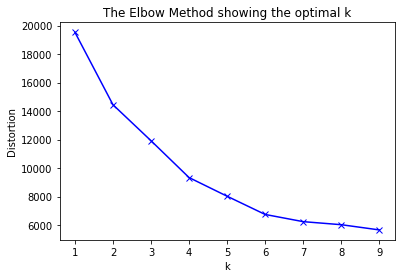

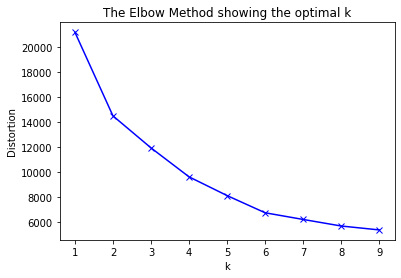

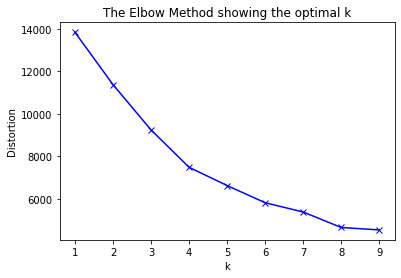

In [20]:
# LANCER LES 2 FONCTIONS :
choisir_nbr_cluster(df_salaire)
choisir_nbr_cluster(df_salaire_idf)
choisir_nbr_cluster(df_salaire_province)

#df_salaire_cluster_3 = kmean_salaire(df_salaire, 3)
df_salaire_cluster_4 = kmean_salaire(df_salaire, 4)

#df_salaire_idf_cluster_3 = kmean_salaire(df_salaire_idf, 3)
df_salaire_idf_cluster_4 = kmean_salaire(df_salaire_idf, 4)

#df_salaire_province_cluster_3 = kmean_salaire(df_salaire_province, 3)
df_salaire_province_cluster_4 = kmean_salaire(df_salaire_province, 4)

# Visualisation des différents clusters générés par le kmean

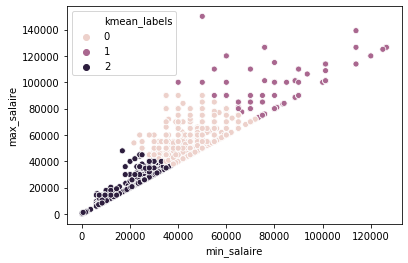

In [21]:
sns.scatterplot(x=df_salaire_cluster_3.min_salaire,y=df_salaire_cluster_3.max_salaire, hue= df_salaire_cluster_3["kmean_labels"])

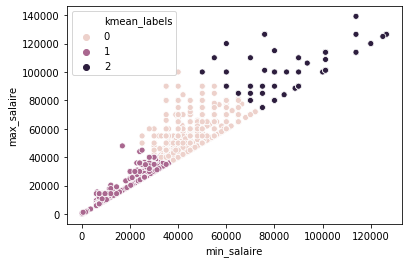

In [22]:
sns.scatterplot(x=df_salaire_idf_cluster_3.min_salaire,y=df_salaire_idf_cluster_3.max_salaire, hue= df_salaire_idf_cluster_3["kmean_labels"])

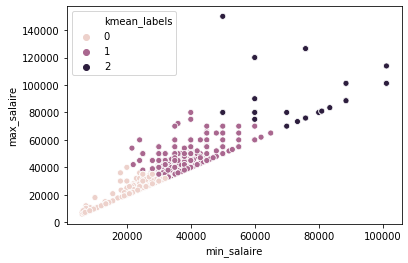

In [23]:
sns.scatterplot(x=df_salaire_province_cluster_3.min_salaire,y=df_salaire_province_cluster_3.max_salaire, hue= df_salaire_province_cluster_3["kmean_labels"])

# Séparation des données en train et test

In [25]:
# Fonction pour spliter les données

def split_train_test(data):
    #selection des variables explicatives
    X = data.loc[:,['junior', 'senior', 'data', 'dev',
                    'bac_3', 'bac_5', 'bac_8',
                    'CDI', 'CDD','freelance_interim', 'stage_apprentissage', 'inconnu',
                    'Nantes', 'Bordeaux','Idf','Lyon','Toulouse',
                   "0", "1" ,"2" ,"3" ,"4" ,"5","6" ,"7" ,"8" ,"9",
                   "10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19"]]
    #selection de la variable à prédire
    salaire_cluster =data["kmean_labels"]
    X_train, X_test, y_train, y_test = train_test_split(X,salaire_cluster, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

In [26]:
#X_train_3, X_test_3, y_train_3, y_test_3 = split_train_test(df_salaire_cluster_3)
X_train_4, X_test_4, y_train_4, y_test_4 = split_train_test(df_salaire_cluster_4)

#X_train_dev, X_test_dev, y_train_dev, y_test_dev = split_train_test(df_salaire_dev_cluster)
#X_train_data, X_test_data, y_train_data, y_test_data = split_train_test(df_salaire_data_cluster)

#X_train_idf_3, X_test_idf_3, y_train_idf_3, y_test_idf_3 = split_train_test(df_salaire_idf_cluster_3)
X_train_idf_4, X_test_idf_4, y_train_idf_4, y_test_idf_4 = split_train_test(df_salaire_idf_cluster_4)

X_train_province_3, X_test_province_3, y_train_province_3, y_test_province_3 = split_train_test(df_salaire_province_cluster_3)
#X_train_province_4, X_test_province_4, y_train_province_4, y_test_province_4 = split_train_test(df_salaire_province_cluster_4)

# Lancer les différents algo de machine learning et trouver les caractéristiques associées - Round 1

Ce premier test nous a permis de tester les différentes variables explicatives et de choisir celles qui étaient pertinentes ou non. Cela nous a aussi permis de tester l'impact de nos divisions de salaire (soit en fonction du pôle dev/data, soit en fonction de la géographie île-de-France/Province.

In [27]:
def machine_learning_round_1(data, X_train, X_test, y_train, y_test):
    X = data.loc[:,['junior', 'senior', 'data', 'dev', 
                    'bac_3', 'bac_5', 'bac_8',
                    'CDI', 'CDD','freelance_interim', 'stage_apprentissage', 'inconnu',
                    'Nantes', 'Bordeaux','Idf','Lyon','Toulouse', 
                   "0", "1" ,"2" ,"3" ,"4" ,"5","6" ,"7" ,"8" ,"9",
                    "10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19"]]
    #selection de la variable à prédire
    salaire_cluster =data["kmean_labels"]
    
    
    #random forest
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(X_train, y_train) 
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    clf_cross_val = cross_val_score(clf, X, salaire_cluster, cv=10, scoring= 'accuracy')
    clf_cross_val_m = clf_cross_val.mean()
    rf_test = accuracy_score(y_test, y_pred_test)
    rf_train = accuracy_score(y_train, y_pred_train)
    rf_recall = recall_score(y_train, y_pred_train, average='weighted')
    rf_f1 = f1_score(y_train, y_pred_train, average='weighted')  

    #SVM Kernel 'linear'       
    SVM = svm.SVC(kernel='linear', random_state=0)
    SVM.fit(X_train, y_train)
    y_pred_test = SVM.predict(X_test)
    y_pred_train = SVM.predict(X_train)
    svm_cross_val = cross_val_score(SVM, X, salaire_cluster, cv=10, scoring= 'accuracy')
    svm_cross_val_m = svm_cross_val.mean()
    svm_test = accuracy_score(y_test, y_pred_test)
    svm_train = accuracy_score(y_train, y_pred_train)
    svm_recall = recall_score(y_train, y_pred_train, average='weighted')
    svm_f1 = f1_score(y_train, y_pred_train, average='weighted')  

    #SVM Kernel 'rbf'
    SVMrbf = svm.SVC(kernel='rbf', random_state=0)
    SVMrbf.fit(X_train, y_train)
    y_pred_test = SVMrbf.predict(X_test)
    y_pred_train = SVMrbf.predict(X_train)
    svm2_cross_val = cross_val_score(SVMrbf, X, salaire_cluster, cv=10, scoring= 'accuracy')
    svm2_cross_val_m = svm2_cross_val.mean()
    svm2_test = accuracy_score(y_test, y_pred_test)
    svm2_train = accuracy_score(y_train, y_pred_train)
    svm2_recall = recall_score(y_train, y_pred_train, average='weighted')
    svm2_f1 = f1_score(y_train, y_pred_train, average='weighted') 

    # Adaboost
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    ada.fit(X_train, y_train)
    y_pred_test = ada.predict(X_test)
    y_pred_train = ada.predict(X_train)
    ada_cross_val = cross_val_score(ada, X, salaire_cluster, cv=10, scoring= 'accuracy')
    ada_cross_val_m = ada_cross_val.mean()
    ada_test = accuracy_score(y_test, y_pred_test)
    ada_train = accuracy_score(y_train, y_pred_train)
    ada_recall = recall_score(y_train, y_pred_train, average='weighted')
    ada_f1 = f1_score(y_train, y_pred_train, average='weighted')

    # XGBoost
    params = {'max_depth': 3,  # the maximum depth of each tree
        'learning_rate': 1.0,  
        'silent': 1, 
        'objective': 'multi:softprob',  
        'n_estimators': 5}  
    bst = XGBClassifier(**params).fit(X_train, y_train)
    y_pred_test = bst.predict(X_test)
    y_pred_train = bst.predict(X_train)
    xg_cross_val = cross_val_score(bst, X, salaire_cluster, cv=10, scoring= 'accuracy')
    xg_cross_val_m = xg_cross_val.mean()
    xg_test = accuracy_score(y_test, y_pred_test)
    xg_train = accuracy_score(y_train, y_pred_train)
    xg_recall = recall_score(y_train, y_pred_train, average='weighted')
    xg_f1 = f1_score(y_train, y_pred_train, average='weighted')
    
    #tableau récapitulatif
    df = pd.DataFrame({'random forest': [rf_train, rf_test, rf_recall, rf_f1, clf_cross_val_m], 
                           'SVM_linear': [svm_train, svm_test, svm_recall, svm_f1, svm_cross_val_m], 
                           'SVM_rbf': [svm2_train, svm2_test, svm2_recall, svm2_f1, svm2_cross_val_m], 
                           'Adaboost': [ada_train, ada_test, ada_recall, ada_f1, ada_cross_val_m ], 
                           'XGBoost': [xg_train, xg_test, xg_recall, xg_f1, xg_cross_val_m]},
                          index = ['accuracy_train', 'accuracy_test', 'recall_train', 'f1_train', 'cross_validation'])
    print(df)
    return df

In [41]:
#machine_learning_round_1(df_salaire_cluster_3, X_train_3, X_test_3, y_train_3, y_test_3)
machine_learning_round_1(df_salaire_cluster_4, X_train_4, X_test_4, y_train_4, y_test_4)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set g

                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.549564    0.660307  0.654085  0.653671  0.745749
accuracy_test          0.541045    0.659204  0.656716  0.644279  0.694030
recall_train           0.549564    0.660307  0.654085  0.653671  0.745749
f1_train               0.453239    0.645483  0.638270  0.652413  0.739330
cross_validation       0.520421    0.652022  0.652949  0.548254  0.644711


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.549564,0.660307,0.654085,0.653671,0.745749
accuracy_test,0.541045,0.659204,0.656716,0.644279,0.694030
recall_train,0.549564,0.660307,0.654085,0.653671,0.745749
f1_train,0.453239,0.645483,0.638270,0.652413,0.739330
cross_validation,0.520421,0.652022,0.652949,0.548254,0.644711


In [42]:
#machine_learning_round_1(df_salaire_idf_cluster_3,X_train_idf_3, X_test_idf_3, y_train_idf_3, y_test_idf_3)
machine_learning_round_1(df_salaire_idf_cluster_4,X_train_idf_4, X_test_idf_4, y_train_idf_4, y_test_idf_4)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set g

                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.634593    0.648760  0.622196  0.591499  0.752656
accuracy_test          0.592920    0.598230  0.582301  0.552212  0.679646
recall_train           0.634593    0.648760  0.622196  0.591499  0.752656
f1_train               0.556623    0.619553  0.511572  0.593886  0.742092
cross_validation       0.609441    0.594627  0.591270  0.551289  0.619091


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.634593,0.648760,0.622196,0.591499,0.752656
accuracy_test,0.592920,0.598230,0.582301,0.552212,0.679646
recall_train,0.634593,0.648760,0.622196,0.591499,0.752656
f1_train,0.556623,0.619553,0.511572,0.593886,0.742092
cross_validation,0.609441,0.594627,0.591270,0.551289,0.619091


In [43]:
#machine_learning_round_1(df_salaire_province_cluster_3,X_train_province_3, X_test_province_3, y_train_province_3, y_test_province_3)
machine_learning_round_1(df_salaire_province_cluster_4,X_train_province_4, X_test_province_4, y_train_province_4, y_test_province_4)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set g

                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.670851    0.697350  0.679219  0.489540  0.831241
accuracy_test          0.648536    0.673640  0.665272  0.460251  0.715481
recall_train           0.670851    0.697350  0.679219  0.489540  0.831241
f1_train               0.556308    0.599884  0.569221  0.506318  0.816168
cross_validation       0.653769    0.631084  0.675810  0.531678  0.660870


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.670851,0.697350,0.679219,0.489540,0.831241
accuracy_test,0.648536,0.673640,0.665272,0.460251,0.715481
recall_train,0.670851,0.697350,0.679219,0.489540,0.831241
f1_train,0.556308,0.599884,0.569221,0.506318,0.816168
cross_validation,0.653769,0.631084,0.675810,0.531678,0.660870


# Améliorer les performances avec Grid Serach

Nous avons choisi de nous interesser aux jeux de données comportant tous les salaire, les salaires en île-de-France et ceux de Province

In [44]:
def grid_search_ML(data):
    #les variables explicatives
    X = data.loc[:,['junior', 'senior', 'data', 'dev', 
                    'bac_3', 'bac_5', 'bac_8',
                    'CDI', 'CDD','freelance_interim', 'stage_apprentissage', 'inconnu',
                    'Nantes', 'Bordeaux','Idf','Lyon','Toulouse',
                    "0", "1" ,"2" ,"3" ,"4" ,"5" ,"6" ,"7" ,"8" ,"9",
                    "10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19"]]
    #selection de la variable à prédire
    salaire_cluster = data["kmean_labels"]

    #random forest
    clf = RandomForestClassifier(random_state=0)
    parameters_randomf = {'n_estimators':[50, 75, 100], 'max_depth':[2, 3, 4, 5]}
    grid = GridSearchCV(clf, parameters_randomf, cv=10, scoring = 'accuracy')
    grid.fit(X, salaire_cluster)
    print(grid.best_params_)
    
    #SVM Kernel 'linear'       
    SVM = svm.SVC(kernel='linear', random_state=0)
    parameters_svc = {'C':[1, 10]}
    grid = GridSearchCV(SVM, parameters_svc, cv=10, scoring = 'accuracy')
    grid.fit(X, salaire_cluster)
    print(grid.best_params_)
    
    #SVM Kernel 'rbf'
    SVMrbf = svm.SVC(kernel='rbf', random_state=0)
    parameters_svcrbf = {'C':[1, 10], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
    grid = GridSearchCV(SVMrbf, parameters_svcrbf, cv=10, scoring = 'accuracy')
    grid.fit(X, salaire_cluster)
    print(grid.best_params_)
    
    # Adaboost
    ada = AdaBoostClassifier(random_state=0)
    parameters_ada = {'n_estimators':[5, 10, 30, 50], 'learning_rate': [1.0, 5.0, 10]}
    grid = GridSearchCV(ada, parameters_ada, cv=10, scoring = 'accuracy')
    grid.fit(X, salaire_cluster)
    print(grid.best_params_)

    # XGBoost
    bst = XGBClassifier()
    parameters_xg = {'max_depth': [1, 3, 5, 7],'learning_rate': [1.0, 5.0, 10], 'n_estimators': [1, 3, 5, 7]}
    grid = GridSearchCV(bst, parameters_xg, cv=10, scoring = 'accuracy')
    grid.fit(X, salaire_cluster)
    print(grid.best_params_)

In [19]:
#grid_search_ML(df_salaire_cluster_3)

{'max_depth': 4, 'n_estimators': 50}
{'C': 1}
{'C': 1, 'gamma': 0.01}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 5}
{'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 3}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
grid_search_ML(df_salaire_cluster_4)

{'max_depth': 5, 'n_estimators': 50}
{'C': 1}
{'C': 10, 'gamma': 0.01}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 30}
{'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 3}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
#grid_search_ML(df_salaire_idf_cluster_3)

{'max_depth': 5, 'n_estimators': 50}
{'C': 1}
{'C': 1, 'gamma': 0.01}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 10}
{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 7}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [46]:
grid_search_ML(df_salaire_idf_cluster_4)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 5, 'n_estimators': 75}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.01}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 10}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 7}


In [23]:
#grid_search_ML(df_salaire_province_cluster_3)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 5, 'n_estimators': 50}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.1}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 10}
{'learning_rate': 1.0, 'max_depth': 7, 'n_estimators': 1}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
grid_search_ML(df_salaire_province_cluster_4)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 4, 'n_estimators': 75}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.1}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1.0, 'n_estimators': 5}
{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 1}


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Lancer les différents algo de machine learning et trouver les caractéristiques associées - Round 2

Nous avons relancés les différents algorithmes avec les paramètres optimisés grâce à Grid Search.
Les précision sur le train ont été améliorée, cependant la cross validations est restée similaire à celle obtenue lors du 1er round.

In [25]:
def machine_learning_round_2(data, X_train, X_test, y_train, y_test, rf_n_estimators, rf_max_depth,
                            svm_C, rbf_c, rbf_gamma, ada_estimators, ada_rate, 
                             xg_max_depth, xg_rate, xg_estimators):
    
    X = data.loc[:,['junior', 'senior', 'data', 'dev', 
                    'bac_3', 'bac_5', 'bac_8',
                    'CDI', 'CDD','freelance_interim', 'stage_apprentissage', 'inconnu',
                    'Nantes', 'Bordeaux','Idf','Lyon','Toulouse',
                   "0", "1" ,"2" ,"3" ,"4" ,"5" ,"6" ,"7" ,"8" ,"9",
                    "10" ,"11" ,"12" ,"13" ,"14" ,"15" ,"16" ,"17" ,"18" ,"19"]]
    #selection de la variable à prédire
    salaire_cluster =data["kmean_labels"]
    
    
    #random forest
    clf = RandomForestClassifier(n_estimators= rf_n_estimators, max_depth=rf_max_depth, random_state=0)
    clf.fit(X_train, y_train) 
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    clf_cross_val = cross_val_score(clf, X, salaire_cluster, cv=10, scoring= 'accuracy')
    clf_cross_val_m = clf_cross_val.mean()
    rf_test = accuracy_score(y_test, y_pred_test)
    rf_train = accuracy_score(y_train, y_pred_train)
    rf_recall = recall_score(y_train, y_pred_train, average='weighted')
    rf_f1 = f1_score(y_train, y_pred_train, average='weighted')  

    #SVM Kernel 'linear'       
    SVM = svm.SVC(kernel='linear', C=svm_C, random_state=0)
    SVM.fit(X_train, y_train)
    y_pred_test = SVM.predict(X_test)
    y_pred_train = SVM.predict(X_train)
    svm_cross_val = cross_val_score(SVM, X, salaire_cluster, cv=10, scoring= 'accuracy')
    svm_cross_val_m = svm_cross_val.mean()
    svm_test = accuracy_score(y_test, y_pred_test)
    svm_train = accuracy_score(y_train, y_pred_train)
    svm_recall = recall_score(y_train, y_pred_train, average='weighted')
    svm_f1 = f1_score(y_train, y_pred_train, average='weighted')  

    #SVM Kernel 'rbf'
    SVMrbf = svm.SVC(kernel='rbf',C=rbf_c, gamma=rbf_gamma, random_state=0)
    SVMrbf.fit(X_train, y_train)
    y_pred_test = SVMrbf.predict(X_test)
    y_pred_train = SVMrbf.predict(X_train)
    svm2_cross_val = cross_val_score(SVMrbf, X, salaire_cluster, cv=10, scoring= 'accuracy')
    svm2_cross_val_m = svm2_cross_val.mean()
    svm2_test = accuracy_score(y_test, y_pred_test)
    svm2_train = accuracy_score(y_train, y_pred_train)
    svm2_recall = recall_score(y_train, y_pred_train, average='weighted')
    svm2_f1 = f1_score(y_train, y_pred_train, average='weighted') 

    # Adaboost
    ada = AdaBoostClassifier(n_estimators= ada_estimators, learning_rate = ada_rate, random_state=0)
    ada.fit(X_train, y_train)
    y_pred_test = ada.predict(X_test)
    y_pred_train = ada.predict(X_train)
    ada_cross_val = cross_val_score(ada, X, salaire_cluster, cv=10, scoring= 'accuracy')
    ada_cross_val_m = ada_cross_val.mean()
    ada_test = accuracy_score(y_test, y_pred_test)
    ada_train = accuracy_score(y_train, y_pred_train)
    ada_recall = recall_score(y_train, y_pred_train, average='weighted')
    ada_f1 = f1_score(y_train, y_pred_train, average='weighted')

    # XGBoost 
    params = {'max_depth': xg_max_depth,  # the maximum depth of each tree
        'learning_rate': xg_rate,  
        'silent': 1, 
        'objective': 'multi:softprob',  
        'n_estimators': xg_estimators}  
    bst = XGBClassifier(**params).fit(X_train, y_train)
    y_pred_test = bst.predict(X_test)
    y_pred_train = bst.predict(X_train)
    xg_cross_val = cross_val_score(bst, X, salaire_cluster, cv=10, scoring= 'accuracy')
    xg_cross_val_m = xg_cross_val.mean()
    xg_test = accuracy_score(y_test, y_pred_test)
    xg_train = accuracy_score(y_train, y_pred_train)
    xg_recall = recall_score(y_train, y_pred_train, average='weighted')
    xg_f1 = f1_score(y_train, y_pred_train, average='weighted')
    
    #tableau récapitulatif
    df = pd.DataFrame({'random forest': [rf_train, rf_test, rf_recall, rf_f1, clf_cross_val_m], 
                           'SVM_linear': [svm_train, svm_test, svm_recall, svm_f1, svm_cross_val_m], 
                           'SVM_rbf': [svm2_train, svm2_test, svm2_recall, svm2_f1, svm2_cross_val_m], 
                           'Adaboost': [ada_train, ada_test, ada_recall, ada_f1, ada_cross_val_m ], 
                           'XGBoost': [xg_train, xg_test, xg_recall, xg_f1, xg_cross_val_m]},
                          index = ['accuracy_train', 'accuracy_test', 'recall_train', 'f1_train', 'cross_validation'])
    print(df)
    return df

In [26]:
#machine_learning_round_2(df_salaire_cluster_3, X_train_3, X_test_3, y_train_3, y_test_3,
                         #4,50, 1, 1, 0.01, 1, 5, 1,3,3)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.940274    0.763998  0.763998  0.700954  0.632518
accuracy_test          0.799751    0.788557  0.788557  0.732587  0.640547
recall_train           0.940274    0.763998  0.763998  0.700954  0.632518
f1_train               0.939066    0.735861  0.735861  0.654059  0.544339
cross_validation       0.718511    0.752502  0.770204  0.624844  0.630522


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.940274,0.763998,0.763998,0.700954,0.632518
accuracy_test,0.799751,0.788557,0.788557,0.732587,0.640547
recall_train,0.940274,0.763998,0.763998,0.700954,0.632518
f1_train,0.939066,0.735861,0.735861,0.654059,0.544339
cross_validation,0.718511,0.752502,0.770204,0.624844,0.630522


In [48]:
machine_learning_round_2(df_salaire_cluster_4, X_train_4, X_test_4, y_train_4, y_test_4,
                         5,50, 1, 10, 0.01, 1, 30, 1,3,5)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.941933    0.660307  0.660307  0.497304  0.473248
accuracy_test          0.685323    0.659204  0.659204  0.495025  0.473881
recall_train           0.941933    0.660307  0.660307  0.497304  0.473248
f1_train               0.941764    0.645483  0.645483  0.440104  0.304040
cross_validation       0.618209    0.652022  0.652643  0.419081  0.457569


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.941933,0.660307,0.660307,0.497304,0.473248
accuracy_test,0.685323,0.659204,0.659204,0.495025,0.473881
recall_train,0.941933,0.660307,0.660307,0.497304,0.473248
f1_train,0.941764,0.645483,0.645483,0.440104,0.304040
cross_validation,0.618209,0.652022,0.652643,0.419081,0.457569


In [28]:
#machine_learning_round_2(df_salaire_idf_cluster_3,X_train_idf_3, X_test_idf_3, y_train_idf_3, y_test_idf_3, 
                         #5, 50, 1, 1, 0.01, 1, 10, 1, 1, 7)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.966942    0.843566  0.843566  0.776860  0.842975
accuracy_test          0.842478    0.840708  0.840708  0.773451  0.838938
recall_train           0.966942    0.843566  0.843566  0.776860  0.842975
f1_train               0.966469    0.822037  0.822037  0.745811  0.821496
cross_validation       0.804444    0.843003  0.843003  0.775942  0.843899


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.966942,0.843566,0.843566,0.776860,0.842975
accuracy_test,0.842478,0.840708,0.840708,0.773451,0.838938
recall_train,0.966942,0.843566,0.843566,0.776860,0.842975
f1_train,0.966469,0.822037,0.822037,0.745811,0.821496
cross_validation,0.804444,0.843003,0.843003,0.775942,0.843899


In [49]:
machine_learning_round_2(df_salaire_idf_cluster_4,X_train_idf_4, X_test_idf_4, y_train_idf_4, y_test_idf_4, 
                         4, 75, 10, 1, 0.01, 1, 10, 1, 5, 7)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.908501    0.684770  0.622196  0.553719  0.276269
accuracy_test          0.610619    0.631858  0.582301  0.518584  0.300885
recall_train           0.908501    0.684770  0.622196  0.553719  0.276269
f1_train               0.907677    0.661326  0.511572  0.450220  0.119606
cross_validation       0.603619    0.618246  0.612174  0.544643  0.311197


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.908501,0.684770,0.622196,0.553719,0.276269
accuracy_test,0.610619,0.631858,0.582301,0.518584,0.300885
recall_train,0.908501,0.684770,0.622196,0.553719,0.276269
f1_train,0.907677,0.661326,0.511572,0.450220,0.119606
cross_validation,0.603619,0.618246,0.612174,0.544643,0.311197


In [30]:
#machine_learning_round_2(df_salaire_province_cluster_3,X_train_province_3, X_test_province_3, y_train_province_3, 
                         #y_test_province_3, 5, 50, 10, 1, 0.01, 1, 10, 1, 7, 1)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.980474    0.856346  0.790795  0.821478  0.821478
accuracy_test          0.828452    0.815900  0.757322  0.803347  0.803347
recall_train           0.980474    0.856346  0.790795  0.821478  0.821478
f1_train               0.980234    0.833812  0.698412  0.769300  0.769300
cross_validation       0.811014    0.835983  0.782515  0.817220  0.817220


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.980474,0.856346,0.790795,0.821478,0.821478
accuracy_test,0.828452,0.815900,0.757322,0.803347,0.803347
recall_train,0.980474,0.856346,0.790795,0.821478,0.821478
f1_train,0.980234,0.833812,0.698412,0.769300,0.769300
cross_validation,0.811014,0.835983,0.782515,0.817220,0.817220


In [50]:
machine_learning_round_2(df_salaire_province_cluster_4,X_train_province_4, X_test_province_4, y_train_province_4, 
                         y_test_province_4, 4, 75, 10, 1, 0.1, 1, 5, 1, 1, 1)

C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  random forest  SVM_linear   SVM_rbf  Adaboost   XGBoost
accuracy_train         0.938633    0.714086  0.698745  0.679219  0.693166
accuracy_test          0.694561    0.702929  0.677824  0.665272  0.669456
recall_train           0.938633    0.714086  0.698745  0.679219  0.693166
f1_train               0.937375    0.638012  0.601732  0.569221  0.600344
cross_validation       0.664760    0.654178  0.652185  0.667389  0.688532


C:\Users\Alexandra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,random forest,SVM_linear,SVM_rbf,Adaboost,XGBoost
accuracy_train,0.938633,0.714086,0.698745,0.679219,0.693166
accuracy_test,0.694561,0.702929,0.677824,0.665272,0.669456
recall_train,0.938633,0.714086,0.698745,0.679219,0.693166
f1_train,0.937375,0.638012,0.601732,0.569221,0.600344
cross_validation,0.664760,0.654178,0.652185,0.667389,0.688532


# Partie Divers

# salaire moyen en fonction des villes

In [32]:
liste_ville = ['Nantes', 'Bordeaux','Idf','Lyon','Toulouse']
liste_salaire_min = []
liste_salaire_max = []

for i in liste_ville :
    salaire_min_mean = df_salaire[df_salaire[i] == 1]["min_salaire"].mean()
    liste_salaire_min.append(salaire_min_mean)
    salaire_max_mean = df_salaire[df_salaire[i] == 1]["max_salaire"].mean()
    liste_salaire_max.append(salaire_max_mean)

df = pd.DataFrame({'Ville': liste_ville, 'salaire_min': liste_salaire_min, 'salaire_max': liste_salaire_max})
df

,Ville,salaire_min,salaire_max
0,Nantes,37210.759336,45449.846473
1,Bordeaux,39193.987654,47510.962963
2,Idf,41568.150952,47659.363878
3,Lyon,35560.865285,43513.683938
4,Toulouse,32501.928144,39933.065868


# Trouver les salaires min et max types dans les k clusters

Afin de présenter le salaire "type" de chaque cluster lors de la présentation client

In [33]:
def trouver_mean_cluster(data):
    liste_kmean = list(data.kmean_labels.unique())
    liste_salaire_moyen_min = []
    liste_salaire_moyen_max = []
    liste_quantite = []
    for i in liste_kmean :
        salaire_min_mean = data[data.kmean_labels == i]["min_salaire"].mean()
        liste_salaire_moyen_min.append(salaire_min_mean)
        salaire_max_mean = data[data.kmean_labels == i]["max_salaire"].mean()
        liste_salaire_moyen_max.append(salaire_max_mean)
        salaire_qte = data[data.kmean_labels == i]["min_salaire"].count()
        liste_quantite.append(salaire_qte)
    df = pd.DataFrame({'kmean': liste_kmean, 'salaire_min': liste_salaire_moyen_min, 'salaire_max': liste_salaire_moyen_max, 'quantite' : liste_quantite})
    print(df)
    return df.sort_values(by=['salaire_min'])

In [34]:
df_salaire_kmean = trouver_mean_cluster(df_salaire_cluster_3)
#df_salaire_kmean = trouver_mean_cluster(df_salaire_cluster_4)
df_salaire_idf_kmean = trouver_mean_cluster(df_salaire_idf_cluster_3)
#df_salaire_idf_kmean = trouver_3mean_cluster(df_salaire_idf_cluster_4)
df_salaire_province_kmean = trouver_mean_cluster(df_salaire_province_cluster_3)
#df_salaire_province_kmean = trouver_mean_cluster(df_salaire_province_cluster_4)

   kmean   salaire_min    salaire_max  quantite
0      2  23508.011696   26307.048733      1026
1      0  44865.108664   52724.208027      2043
2      1  86269.527397  103227.445205       146
   kmean   salaire_min    salaire_max  quantite
0      0  46883.411493   54421.196169      1514
1      1  21219.872274   22880.314642       642
2      2  90270.000000  102715.048544       103
   kmean   salaire_min    salaire_max  quantite
0      1  36910.292781   44906.495989       748
1      0  21381.073171   24372.829268       164
2      2  76275.909091  102911.136364        44
